In [21]:
import os
import glob
import re
from typing import List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud

In [22]:
FOLDER_MINUTES_TXT = "./data/processed/copom_minutes_processed" 

In [ ]:
def download_nltk_resources():
    """
    #Verifica e baixa os recursos necessários do NLTK.
    """
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab', quiet=True)

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords', quiet=True)

    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet', quiet=True)

    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger', quiet=True)

    try:
        nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    except LookupError:
        nltk.download('averaged_perceptron_tagger_eng', quiet=True)


download_nltk_resources()

In [38]:
def analyze_text(text: str) -> Dict[str, Any]:
    """
    #Calcula um conjunto de métricas para um dado texto.
    """
    lower_text = text.lower()
    text_wo_punctuation = re.sub(r'[^\w\s]', '', lower_text)
    tokens = text_wo_punctuation.split()


    word_count = len(tokens)
    

    paragraphs = [p for p in text.split('\n\n') if p.strip()]
    paragraph_count = len(paragraphs)
    

    if word_count == 0:
        lexical_diversity = 0
    else:
        unique_words = len(set(tokens))
        lexical_diversity = unique_words / word_count
        
        
    return {
        "word_count": word_count,
        "paragraph_count": paragraph_count,
        "lexical_diversity": lexical_diversity
    }

In [25]:
filepaths = glob.glob(f"{FOLDER_MINUTES_TXT}/*.txt")

minutes_info = pd.read_excel("./data/raw/minutes_info.xlsx")
minutes_info['DataReferencia'] = pd.to_datetime(minutes_info['DataReferencia'])

In [26]:


all_minutes_data = []
full_corpus_text = []

for path in filepaths:
    filename = os.path.basename(path)

    # Getting date
    minutes_info_temp = minutes_info.copy()
    minutes_info_temp = minutes_info_temp[minutes_info_temp["Titulo"] == filename.replace(".txt", "")]
    date = minutes_info_temp["DataReferencia"].values[0]
    
    if date is None:
        print(f"AVISO: Não foi possível extrair a data do arquivo '{filename}'. Ele será ignorado nas análises de tempo.")
        continue
        
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()
        full_corpus_text.append(text)
        
    metrics = analyze_text(text)
    
    all_minutes_data.append({
        "filename": filename,
        "date": date,
        **metrics
    })

In [27]:
df = pd.DataFrame(all_minutes_data)
df = df.sort_values(by='date').reset_index(drop=True)
df['year'] = df['date'].dt.year

In [28]:
print("\nResumo das métricas calculadas:")
print(df[['word_count', 'paragraph_count', 'lexical_diversity']].describe())


Resumo das métricas calculadas:
        word_count  paragraph_count  lexical_diversity
count   221.000000       221.000000         221.000000
mean   4606.230769        55.366516           0.256952
std    2545.824788        24.016407           0.062358
min     126.000000         3.000000           0.179741
25%    2193.000000        32.000000           0.201735
50%    4201.000000        64.000000           0.256820
75%    6994.000000        77.000000           0.285588
max    9363.000000        93.000000           0.658730


In [29]:
sns.set_theme(style="whitegrid", palette="viridis")

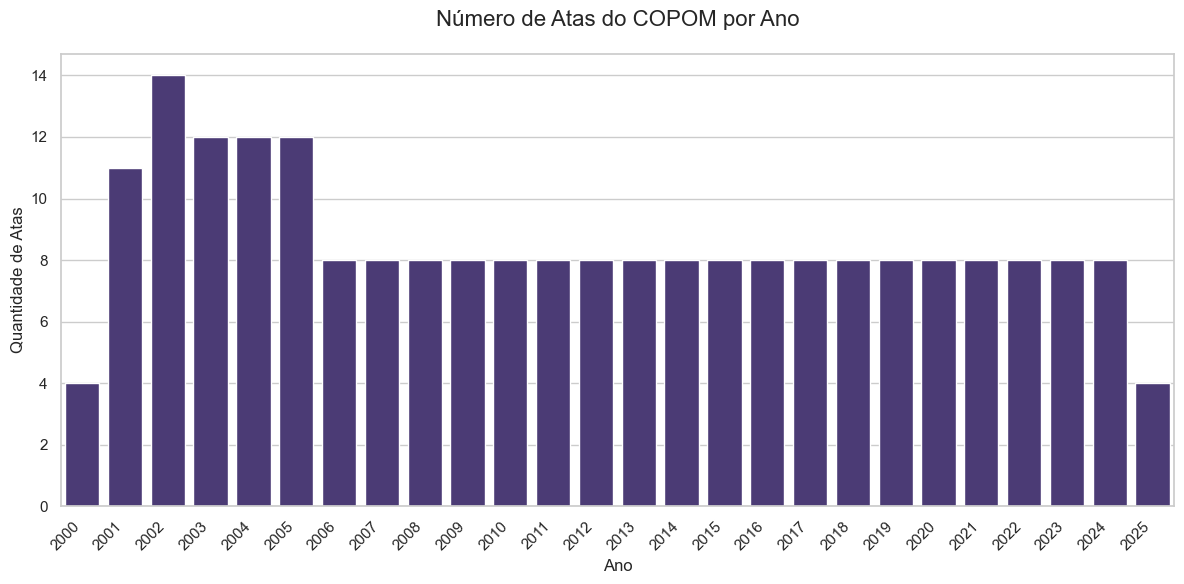

In [30]:
# Gráfico 1: Número de Atas por Ano
plt.figure(figsize=(12, 6))
minutes_per_year = df.groupby('year').size()
sns.barplot(x=minutes_per_year.index, y=minutes_per_year.values)
plt.title('Número de Atas do COPOM por Ano', fontsize=16, pad=20)
plt.xlabel('Ano')
plt.ylabel('Quantidade de Atas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.close()


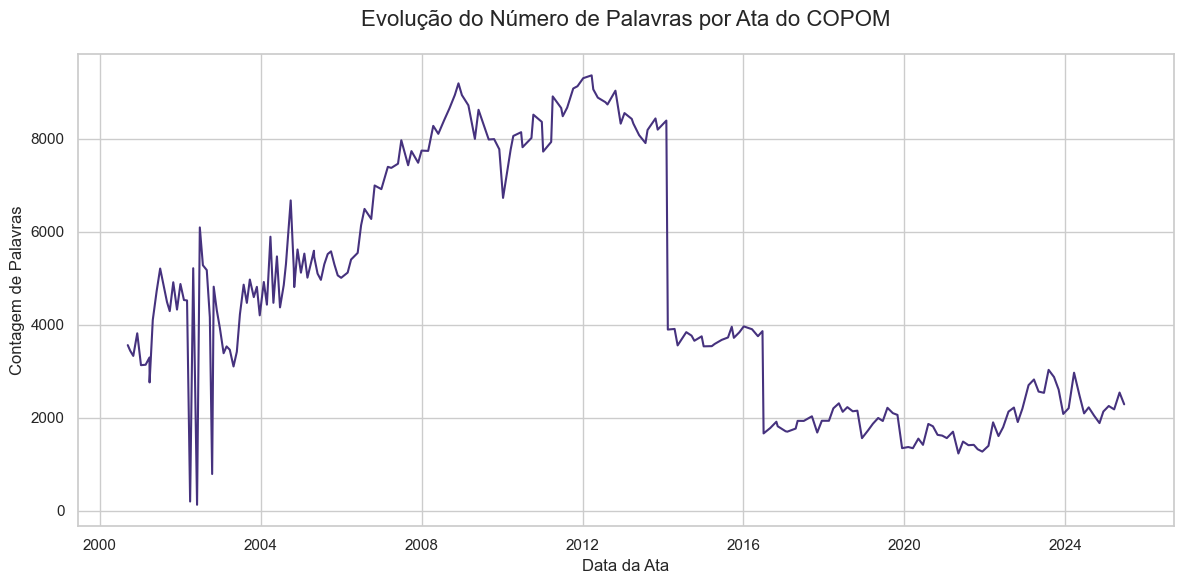

In [31]:
# Gráfico 2: Evolução do Número de Palavras
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='word_count')
plt.title('Evolução do Número de Palavras por Ata do COPOM', fontsize=16, pad=20)
plt.xlabel('Data da Ata')
plt.ylabel('Contagem de Palavras')
plt.tight_layout()
plt.show()

plt.close()

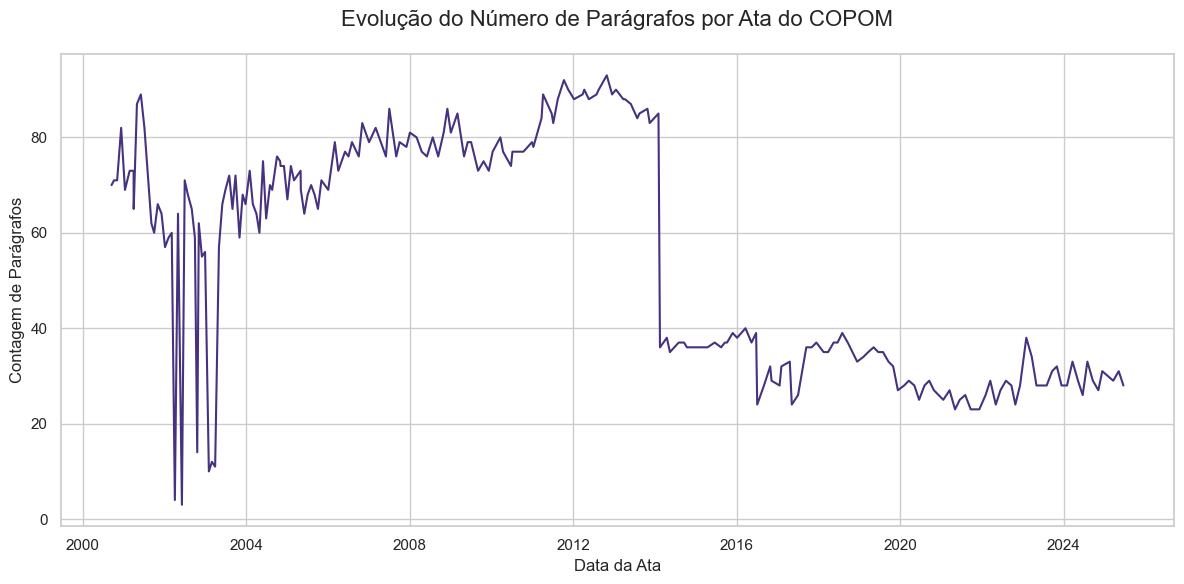

In [32]:
# Gráfico 3: Evolução do Número de Parágrafos
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='paragraph_count')
plt.title('Evolução do Número de Parágrafos por Ata do COPOM', fontsize=16, pad=20)
plt.xlabel('Data da Ata')
plt.ylabel('Contagem de Parágrafos')
plt.tight_layout()
plt.show()

plt.close()

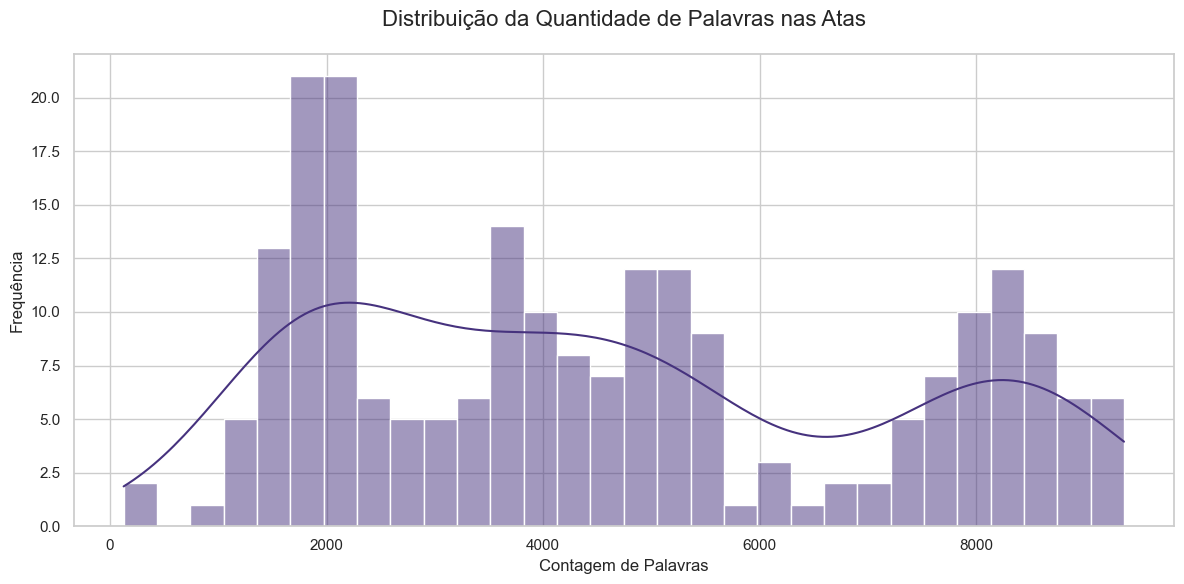

In [33]:
# Gráfico 4: Histograma da Contagem de Palavras
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], kde=True, bins=30)
plt.title('Distribuição da Quantidade de Palavras nas Atas', fontsize=16, pad=20)
plt.xlabel('Contagem de Palavras')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

plt.close()

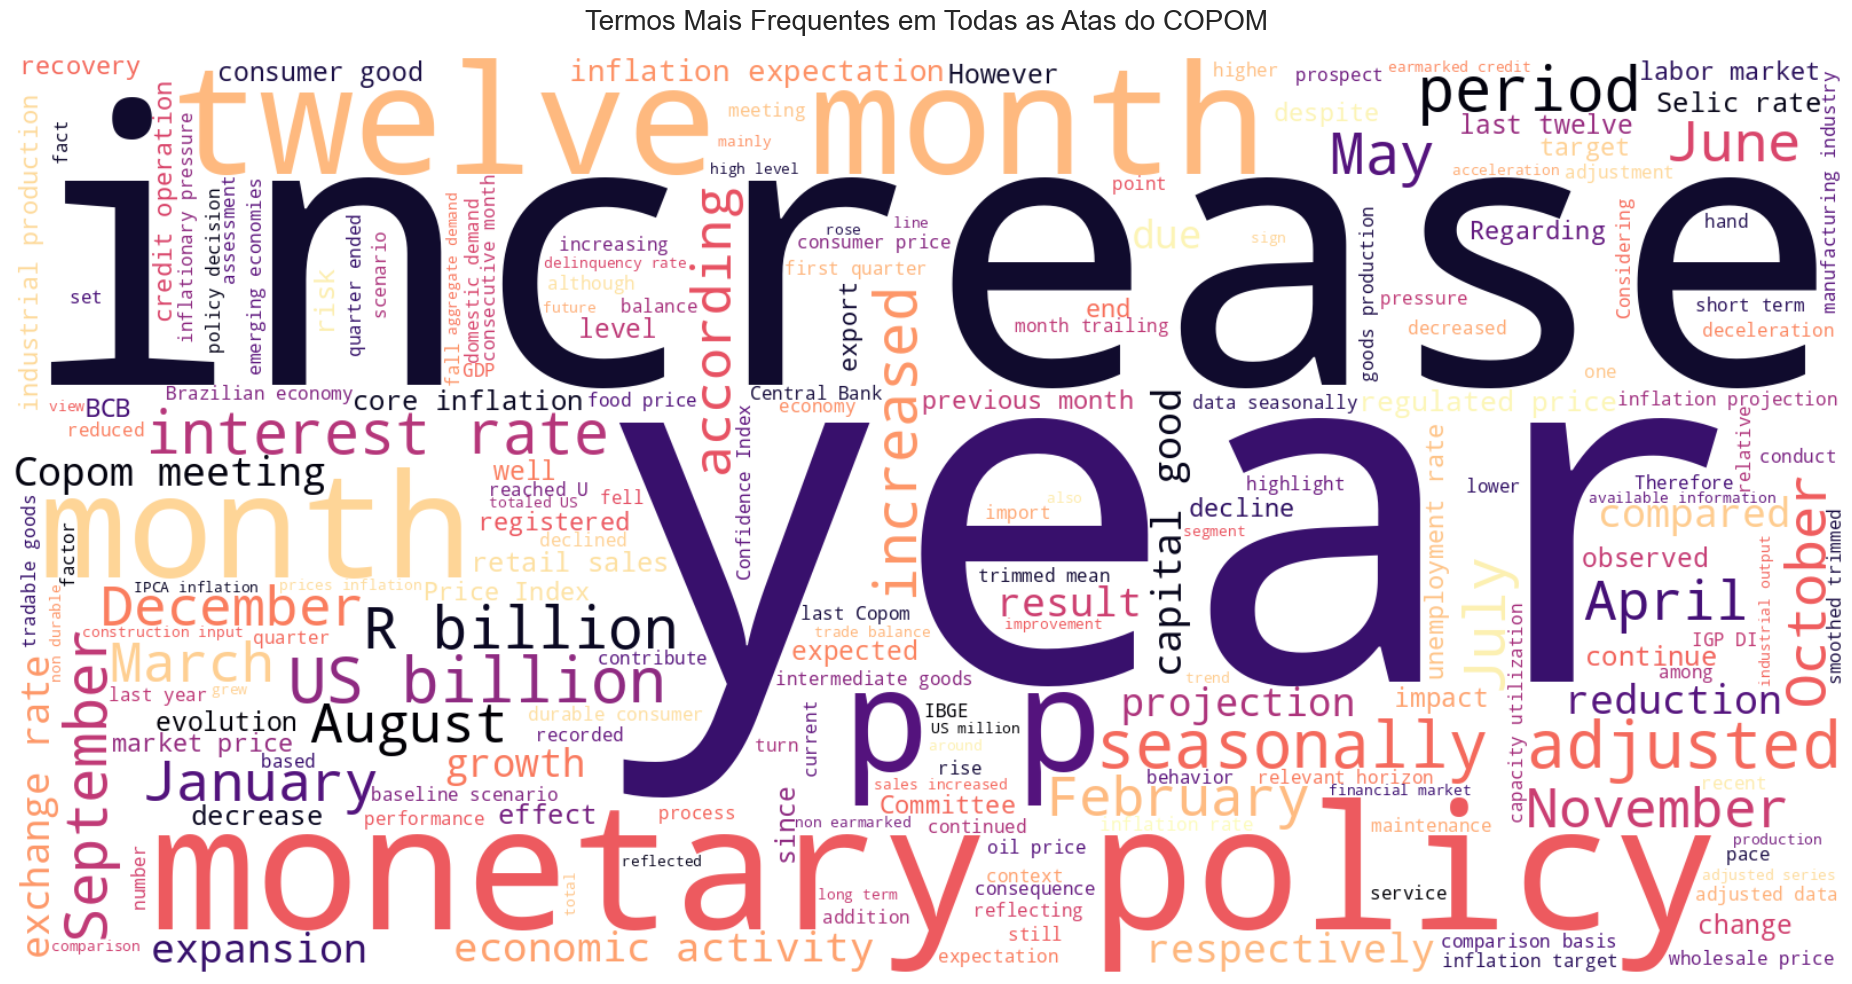

In [34]:
# Gráfico 5: Nuvem de Palavras
all_minutes_text = " ".join(full_corpus_text)
stopwords_set = set(nltk.corpus.stopwords.words('english'))

wordcloud = WordCloud(
    stopwords=stopwords_set, background_color="white", width=1600, height=800,
    max_words=200, colormap='magma'
).generate(all_minutes_text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Termos Mais Frequentes em Todas as Atas do COPOM', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

plt.close()

In [39]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

In [40]:
lemmatizer = nltk.WordNetLemmatizer()

tokens = nltk.word_tokenize(all_minutes_text.lower())
tagged_tokens = nltk.pos_tag(tokens)

lemmatized_words = []
for word, tag in tagged_tokens:
    pos = get_wordnet_pos(tag)
    if len(word) > 2:
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)


lemmatized_text_for_cloud = " ".join(lemmatized_words)

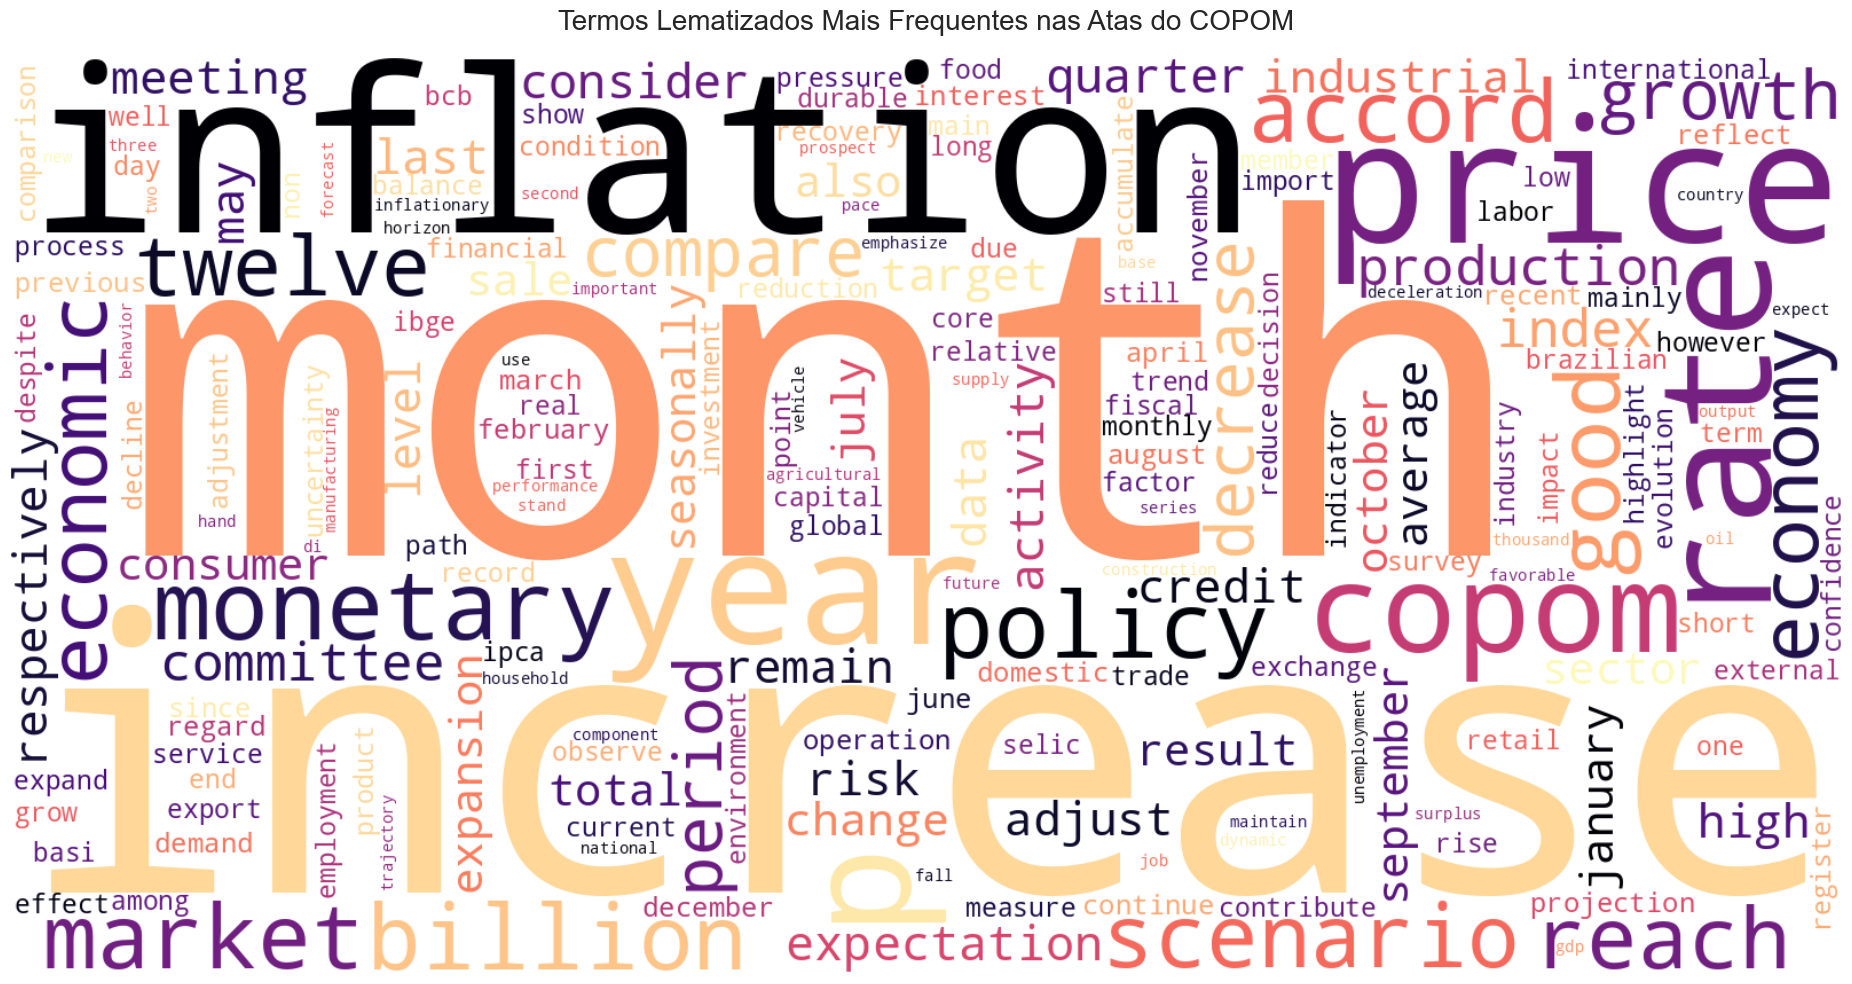

In [41]:
# Gráfico 5: Nuvem de Palavras Lematizada

stopwords_set = set(nltk.corpus.stopwords.words('english'))

wordcloud = WordCloud(
    stopwords=stopwords_set,
    background_color="white",
    width=1600,
    height=800,
    max_words=200,
    colormap='magma',
    collocations=False # Evita que a nuvem mostre bigramas (ex: "interest rate")
).generate(lemmatized_text_for_cloud)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Termos Lematizados Mais Frequentes nas Atas do COPOM', fontsize=20, pad=20)
plt.tight_layout()
plt.show()